### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research here!). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 




-----
## My implementation

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import corner
from scipy.stats import loguniform
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix


color = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']

### Read data

In [2]:
#download
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open('Summary_table.txt', 'wb') as f:
    f.write(r.content)
    
#read
data = np.loadtxt('summary_table.txt', dtype='str', unpack='True')

#read headers
with open('Summary_table.txt', 'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
print(names.shape)
print(names)

(15,)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [4]:
print(data.shape)
print(data)

(15, 8014)
[['GRB221218A' 'GRB221216A' 'GRB221215B' ... 'GRB910424A*' 'GRB910423A*'
  'GRB910421A*']
 ['None' 'GRB221216473' 'GRB221215673' ... 'None' 'None' 'None']
 ['8:14:10' '11:21:05.640' '16:09:25.879' ... '19:43:25.064'
  '19:51:15.804' '9:14:03.800']
 ...
 ['-999' '184.3240' '65.7930' ... '3.1360' '208.5760' '5.6960']
 ['False' 'False' 'True' ... 'False' 'False' 'False']
 ['59931.34317130' '59929.47298194' '59928.67321619' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]


In [5]:
print(data[3])

['350.6495' '326.0300' '23.2300' ... '201.3000' '193.4750' '270.6750']


In [6]:
# trasform data (which are strings) in float
T90 = np.array(data[6], dtype=float)
T90_error = np.array(data[7], dtype=float)
fluence = np.array(data[9], dtype=float)
fluence_error = np.array(data[10], dtype=float)
redshift = np.array(data[11], dtype=float)

##### functions

In [100]:
'''
When classify data in SGRB and LGRB, it makes sure that
label 0 is assigned to SGRB and 1 to LGRB.

Arguments: whole dataset, lables from the classification
'''
def invert_labels(data, labels):
    a = np.where(data == max(data))
    if (labels[a] == 0):
        for i in range(len(data)):# invert labels for each sample
            if labels[i] == 0:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 0
    return labels



'''
Data are classified in log scale.
When we do two histograms of the two classes of data, use this
function to set the right bins.

Arguments: data classified as SGRB, data classified as LGRB
'''
def binlims(dataSGRB, dataLGRB):
    minbinshort = np.log10(min(dataSGRB))
    maxbinshort = np.log10(max(dataSGRB))
    minbinlong = np.log10(min(dataLGRB))
    maxbinlong = np.log10(max(dataLGRB))
    return minbinshort, maxbinshort, minbinlong, maxbinlong


def distance(value1, value2):
    return abs(value1-value2)/np.median([value1, value2])


'''
returns the label of the classes with lower T90 and higher T90 values respectively
'''
def return_label(data, labels):
    a = np.where(data == max(data))
    b = np.where(data == min(data))
    return labels[b], labels[a]

### T90

I start doing a simple histogram:

In [8]:
mask = T90!= -999

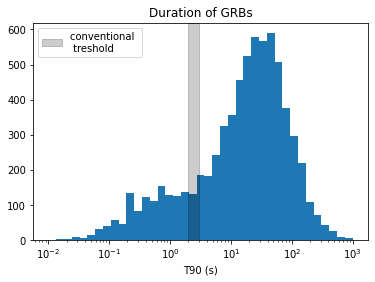

In [11]:
plt.hist(T90[mask], bins=np.logspace(-2, 3, 40))
plt.title('Duration of GRBs')
plt.semilogx()
plt.axvspan(2, 3, alpha=0.2, color='black', label='conventional \n treshold')
plt.xlabel('T90 (s)')
plt.legend();

It seems there are two Gaussians. I thus use Gaussian Mixture algorithm with 2 components.

### Clustering with Gaussian Mixture

In [12]:
# fit the model: 2 Gaussians
gm = GaussianMixture(n_components=2).fit(np.log10(T90[mask])[:, np.newaxis])


# pdf model
xgrid = np.logspace(-2, 3, 1000)
pdf = np.exp(gm.score_samples(np.log10(xgrid)[:, np.newaxis]))

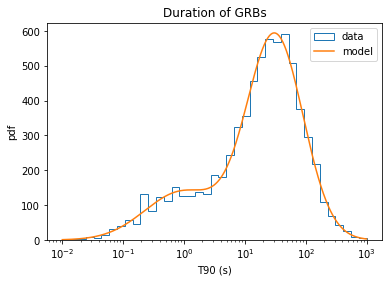

In [13]:
# see how the model fits data
plt.hist(T90[mask], bins=np.logspace(-2, 3, 40), histtype='step', label='data')
plt.plot(xgrid, pdf*900, label='model')
plt.title('Duration of GRBs')
plt.xlabel('T90 (s)')
plt.ylabel('pdf')
plt.legend()
plt.semilogx();

okay, the model is working well. Now I get centers and the treshold

In [14]:
# LABELS
gmlabels = gm.predict(np.log10(T90[mask])[:, np.newaxis])
gmlabels = invert_labels(T90[mask], gmlabels)                # make sure SGRB label==0, LGRB label==1


# get the two samples:
GMshort = T90[mask][gmlabels == 0]
GMlong = T90[mask][gmlabels == 1]


# get the treshold and the centers
GMtreshold = np.median([max(GMshort), min(GMlong)])
GMcenters = [np.median(GMshort), np.median(GMlong)]

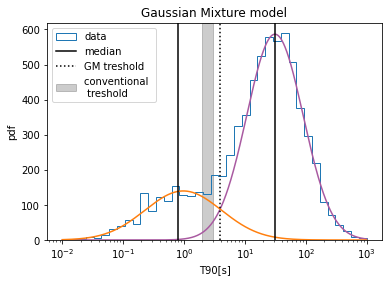

In [18]:
# plot the results of the classification

x = np.logspace(-2, 3, 1000)


# compute the modes 
resp = gm.predict_proba(np.log10(x[:, np.newaxis]))
modes = [resp[:,0] * pdf, resp[:,1] * pdf]


# plot
plt.hist(T90[mask], bins=np.logspace(-2, 3, 40), histtype='step', label='data')
plt.plot(x, modes[0]*900, color=color[1])
plt.plot(x, modes[1]*900)
plt.axvline(GMcenters[0], color='black', label='median')
plt.axvline(GMcenters[1], color='black')
plt.axvline(GMtreshold, color='black', linestyle='dotted', label='GM treshold')
plt.axvspan(2, 3, alpha=0.2, color='black', label='conventional \n treshold')


plt.legend()
plt.xlabel('T90[s]')
plt.title('Gaussian Mixture model')
plt.ylabel('pdf')
plt.semilogx();

I look at the classification on histograms to see if everything is working in the right way

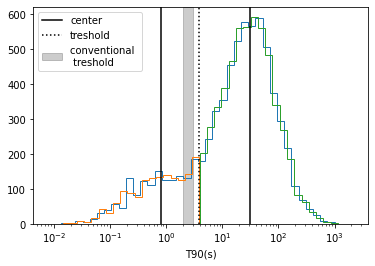

In [19]:
# If I use -2,3 as before the hist changes shape (since bins are too big/small)
minbinshort, maxbinshort, minbinlong, maxbinlong = binlims(GMshort,
                                                           GMlong)


plt.hist(T90[mask], bins=np.logspace(-2,3,40), histtype='step')
plt.hist(GMshort, bins=np.logspace(minbinshort, maxbinshort, 22), histtype='step')
plt.hist(GMlong, bins=np.logspace(minbinlong , maxbinlong, 22), histtype='step')

plt.axvline(GMcenters[0],color='black', label='center')
plt.axvline(GMcenters[1],color='black')
plt.axvline(GMtreshold,color='black', linestyle='dotted', label = 'treshold')
plt.axvspan(2, 3, alpha=0.2, color='black', label='conventional \n treshold')


plt.xlabel('T90(s)')
plt.semilogx()
plt.legend();

### Clustering with kmeans

Now I do the classification with kMeans to see if I get similar results 

In [20]:
# kmeans with 2 clusters
km = KMeans(n_clusters=2)
km.fit(np.log10(T90[mask][:, np.newaxis]))


# centers and labels
KMcenters = 10 ** km.cluster_centers_ 
kmlabels = km.predict(np.log10(T90[mask][:, np.newaxis]))
#print(centers.shape, centers)
kmlabels = invert_labels(T90[mask], kmlabels)


#make sure centers[0] is for SGRB and centers[1] for LGRB
if KMcenters[0]>KMcenters[1]:
    KMcenters = np.roll(KMcenters, shift=1)


# get the two samples:
KMshort = T90[mask][kmlabels == 0]
KMlong = T90[mask][kmlabels == 1]

# get the treshold 
KMtreshold = np.median([max(KMshort), min(KMlong)])

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


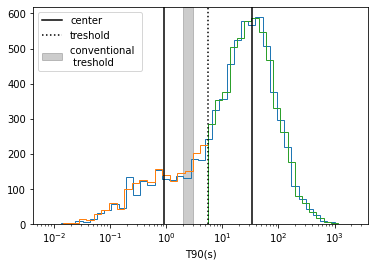

In [21]:
# plot all
minbinshort, maxbinshort, minbinlong, maxbinlong = binlims(KMshort,KMlong)

# plot hist
plt.hist(T90[mask], bins=np.logspace(-2,3,40), histtype='step')
plt.hist(KMshort, bins=np.logspace(minbinshort, maxbinshort, 22), histtype='step')
plt.hist(KMlong, bins=np.logspace(minbinlong , maxbinlong, 21), histtype='step')

plt.axvline(KMcenters[0],color='black', label='center')
plt.axvline(KMcenters[1],color='black')
plt.axvline(KMtreshold,color='black', linestyle='dotted', label = 'treshold')
plt.axvspan(2, 3, alpha=0.2, color='black', label='conventional \n treshold')

plt.xlabel('T90(s)')
plt.semilogx()
plt.legend();

### Compare the two models

I print a summary of the two models results

In [22]:
print('Treshold [s] found with: \n Gaussian Mixture:', GMtreshold, 
     '\n kMeans:', KMtreshold)
print('Centers for Gaussian Mixture & kMeans respectively [s]: \n SGRBs:',  GMcenters[0], 
      KMcenters[0], '\n LGRB:', GMcenters[1], 
      KMcenters[1])

Treshold [s] found with: 
 Gaussian Mixture: 3.927 
 kMeans: 5.544
Centers for Gaussian Mixture & kMeans respectively [s]: 
 SGRBs: 0.8 [0.91383169] 
 LGRB: 30.799999999999997 [33.6538195]


The Gaussian Mixture model estimated treshold is nearer to the conventional one.
Check how distant is the treshold for the two models from $3s$:

In [23]:
print('distance of GM and KM treshold from 3s respectively:')
abs(GMtreshold-3)/3, abs(KMtreshold-3)/3

distance of GM and KM treshold from 3s respectively:


(0.309, 0.8479999999999999)

Check how distant are the central points and the treshold of two models:

In [24]:
dTreshold = distance(GMtreshold,KMtreshold)
dCentersShort = distance(KMcenters[0],GMcenters[0])
dCentersLong = distance(KMcenters[1],GMcenters[1])

print('Distances between GM and KM:')
print('treshold            center SGRB   center LGRB')
print(dTreshold, dCentersShort, dCentersLong)

Distances between GM and KM:
treshold            center SGRB   center LGRB
0.34146341463414626 [0.13283882] [0.08855393]


/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


I now consider the treshold of $3s$ as the true treshold and I label the original dataset with 0 for GRB with $T_{90} < = 3s$ (SGRB), and 1 for for GRB with $T_{90} >3s$ (LGRB).

In [25]:
# TrueLabels = 0 for SGRB, 1 for LGRB
TrueLabels =  []
for i in range(len(T90[mask])):
    if T90[mask][i]>3:
        TrueLabels.append(1)
    else:
        TrueLabels.append(0)  
        
TrueLabels = np.array(TrueLabels)

print('Confusion matrix GM: \n', confusion_matrix(TrueLabels, gmlabels))
print('Confusion matrix KM: \n', confusion_matrix(TrueLabels, kmlabels))

Confusion matrix GM: 
 [[1396    0]
 [ 161 5442]]
Confusion matrix KM: 
 [[1396    0]
 [ 403 5200]]


The long GRB that are identified as short are much less using GM rather than using KM. Indeed, the GM treshold is closer to $3s$

### Outliers

I add random noise to data. I add separatly data with lower and upper values respect to the initial dataset.
Let's see what happens!


In [170]:
'''ADD OUTLIERS (2% of the T90 dataset) according to a log uniform '''

size = int(len(T90[mask])*0.02)    # outliers size

# create the outliers
random.seed(8)
lower_outliers = loguniform.rvs(10**-3, 10**-2, size=size)
upper_outliers = loguniform.rvs(10**3, 10**4, size=size)

# add outliers to data
T90_lower = np.append(T90[mask], lower_outliers)
T90_upper = np.append(T90[mask], upper_outliers)

In [171]:
# CLASSIFICATION



# -------------------- LOWER OUTLIERS ------------------
# Gaussian Mixture
gm_lower = GaussianMixture(n_components=2).fit(np.log10(T90_lower)[:, np.newaxis])
gmlabels_lower = gm_lower.predict(np.log10(T90_lower)[:, np.newaxis]) 
gmlabels_lower = invert_labels(T90_lower, gmlabels_lower)


# KMeans
km_lower = KMeans(n_clusters=2).fit(np.log10(T90_lower)[:, np.newaxis])
kmlabels_lower = km_lower.predict(np.log10(T90_lower)[:, np.newaxis]) 
kmlabels_lower = invert_labels(T90_lower, kmlabels_lower)


# get the treshold and the centers
GMtreshold_lower = np.median([max(T90_lower[gmlabels_lower == 0]), min(T90_lower[gmlabels_lower == 1])])
GMcenters_lower = [np.median(T90_lower[gmlabels_lower == 0]), np.median(T90_lower[gmlabels_lower == 1])]

KMtreshold_lower = np.median([max(T90_lower[kmlabels_lower == 0]), min(T90_lower[kmlabels_lower == 1])])
KMcenters_lower = [np.median(T90_lower[kmlabels_lower == 0]), np.median(T90_lower[kmlabels_lower == 1])]




# ------------------- UPPER OUTLIERS -------------------

#GM
gm_upper = GaussianMixture(n_components=2).fit(np.log10(T90_upper)[:, np.newaxis])
gmlabels_upper = gm_upper.predict(np.log10(T90_upper)[:, np.newaxis]) 
gmlabels_upper = invert_labels(T90_upper, gmlabels_upper)

# KMeans
km_upper = KMeans(n_clusters=2).fit(np.log10(T90_upper)[:, np.newaxis])
kmlabels_upper = km_upper.predict(np.log10(T90_upper)[:, np.newaxis]) 
kmlabels_upper = invert_labels(T90_upper, kmlabels_upper)

# get the treshold and the centers
GMtreshold_upper = np.median([max(T90_upper[gmlabels_upper == 0]), min(T90_upper[gmlabels_upper == 1])])
GMcenters_upper = [np.median(T90_upper[gmlabels_upper == 0]), np.median(T90_upper[gmlabels_upper == 1])]

KMtreshold_upper = np.median([max(T90_upper[kmlabels_upper == 0]), min(T90_upper[kmlabels_upper == 1])])
KMcenters_upper = [np.median(T90_upper[kmlabels_upper == 0]), np.median(T90_upper[kmlabels_upper == 1])]

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


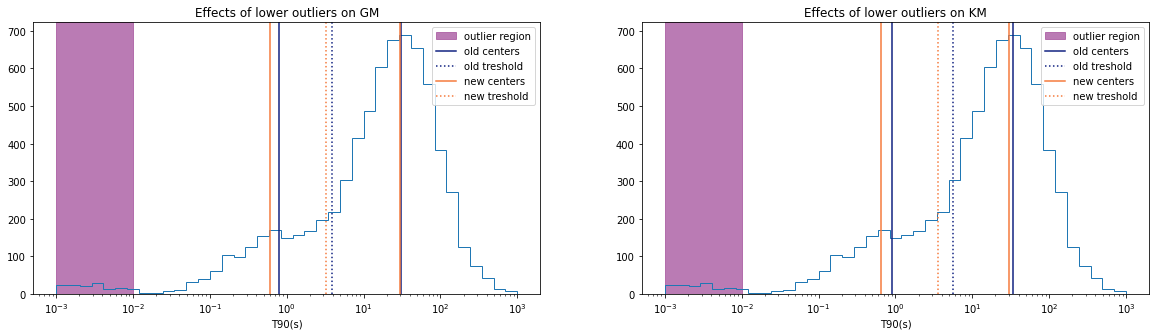

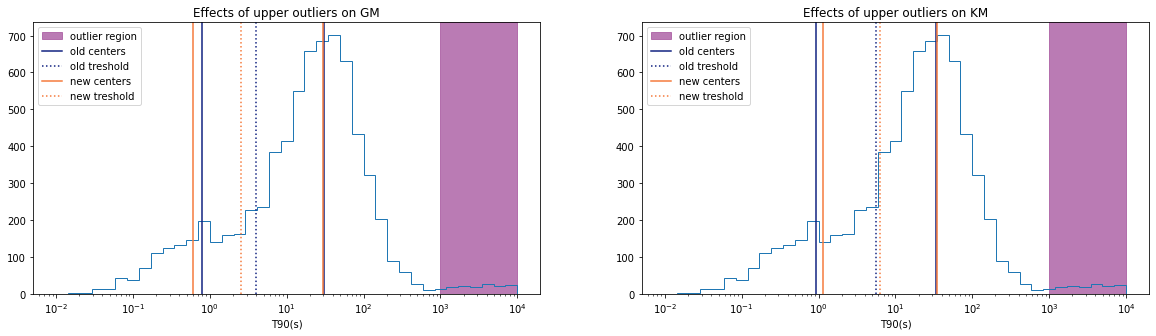

In [172]:
# PLOT THE RESULTS
fig = plt.figure(figsize=(20, 5))

#----------------------------- GM, lower outliers------------------------
ax1 = fig.add_subplot(121) 

plt.hist(T90_lower, bins=np.logspace(-3,3,40), histtype='step')
plt.axvspan(10**-3, 10**-2, color=color[1], alpha=0.8, label='outlier region')

# old centers & treshold
plt.axvline(GMcenters[0],color=color[3], label='old centers')
plt.axvline(GMcenters[1],color=color[3])
plt.axvline(GMtreshold,color=color[3], linestyle='dotted', label = 'old treshold')

# new centers & treshold
plt.axvline(GMcenters_lower[0],color=color[0], label='new centers')
plt.axvline(GMcenters_lower[1],color=color[0])
plt.axvline(GMtreshold_lower,color=color[0], linestyle='dotted', label = 'new treshold')

plt.title('Effects of lower outliers on GM')
plt.xlabel('T90(s)')

plt.legend()
plt.semilogx()

# --------------------------- KM, lower outliers -------------------
ax2 = fig.add_subplot(122) 

plt.hist(T90_lower, bins=np.logspace(-3,3,40), histtype='step')
plt.axvspan(10**-3, 10**-2, color=color[1], alpha=0.8, label='outlier region')

# old centers & treshold
plt.axvline(KMcenters[0],color=color[3], label='old centers')
plt.axvline(KMcenters[1],color=color[3])
plt.axvline(KMtreshold,color=color[3], linestyle='dotted', label = 'old treshold')

# new centers & treshold
plt.axvline(KMcenters_lower[0],color=color[0], label='new centers')
plt.axvline(KMcenters_lower[1],color=color[0])
plt.axvline(KMtreshold_lower,color=color[0], linestyle='dotted', label = 'new treshold')

plt.title('Effects of lower outliers on KM')
plt.xlabel('T90(s)')

plt.legend()
plt.semilogx();


fig = plt.figure(figsize=(20,5))


#----------------------------- GM upper outliers --------------
ax1 = fig.add_subplot(121) 

plt.hist(T90_upper, bins=np.logspace(-2,4,40), histtype='step')
plt.axvspan(10**3, 10**4, color=color[1], alpha=0.8, label='outlier region')

# old centers & treshold
plt.axvline(GMcenters[0],color=color[3], label='old centers')
plt.axvline(GMcenters[1],color=color[3])
plt.axvline(GMtreshold,color=color[3], linestyle='dotted', label = 'old treshold')

# new centers & treshold
plt.axvline(GMcenters_upper[0],color=color[0], label='new centers')
plt.axvline(GMcenters_upper[1],color=color[0])
plt.axvline(GMtreshold_upper,color=color[0], linestyle='dotted', label = 'new treshold')

plt.title('Effects of upper outliers on GM')
plt.xlabel('T90(s)')

#plt.xlim(10**1, 10**2)
plt.legend()
plt.semilogx()




# ----------------------------------- KM upper outliers -------------------
ax2 = fig.add_subplot(122) 

plt.hist(T90_upper, bins=np.logspace(-2,4,40), histtype='step')
plt.axvspan(10**3, 10**4, color=color[1], alpha=0.8, label='outlier region')

# old centers & treshold
plt.axvline(KMcenters[0],color=color[3], label='old centers')
plt.axvline(KMcenters[1],color=color[3])
plt.axvline(KMtreshold,color=color[3], linestyle='dotted', label = 'old treshold')

# new centers & treshold
plt.axvline(KMcenters_upper[0],color=color[0], label='new centers')
plt.axvline(KMcenters_upper[1],color=color[0])
plt.axvline(KMtreshold_upper,color=color[0], linestyle='dotted', label = 'new treshold')

plt.title('Effects of upper outliers on KM')
plt.xlabel('T90(s)')

plt.legend()
plt.semilogx();

In [173]:
# check the distance between old & new treshold/centers


# lower outliers
dShortCenter_gm = distance(GMcenters[0],GMcenters_lower[0])
dLongCenter_gm = distance(GMcenters[1],GMcenters_lower[1])
dTreshold_gm = distance(GMtreshold,GMtreshold_lower)

dShortCenter_km = distance(KMcenters[0],KMcenters_lower[0])
dLongCenter_km = distance(KMcenters[1],KMcenters_lower[1])
dTreshold_km = distance(KMtreshold,KMtreshold_lower)

print(f'\n How distant is the outcome with outliers respect to original data model? \n \n',
      '\n LOWER OUTLIERS: \n \n',
      '            GM    KMeans')
print('SGRB center: %.2f' %dShortCenter_gm, ' %.2f'%dShortCenter_km)
print('LGRB center: %.2f' %dLongCenter_gm,  ' %.2f'%dLongCenter_km)
print('Treshold:    %.2f' %dTreshold_gm,    ' %.2f'%dTreshold_km)



# upper outliers

dShortCenter_gm = distance(GMcenters[0],GMcenters_upper[0])
dLongCenter_gm = distance(GMcenters[1],GMcenters_upper[1])
dTreshold_gm = distance(GMtreshold,GMtreshold_upper)

dShortCenter_km = distance(KMcenters[0],KMcenters_upper[0])
dLongCenter_km = distance(KMcenters[1],KMcenters_upper[1])
dTreshold_km = distance(KMtreshold,KMtreshold_upper)

print(f'\n \n  UPPER OUTLIERS: \n \n',
      '              GM  KMeans')
print('SGRB center: %.2f' %dShortCenter_gm, ' %.2f'%dShortCenter_km)
print('LGRB center: %.2f' %dLongCenter_gm,  ' %.2f'%dLongCenter_km)
print('Treshold:    %.2f' %dTreshold_gm,    ' %.2f'%dTreshold_km);


 How distant is the outcome with outliers respect to original data model? 
 
 
 LOWER OUTLIERS: 
 
             GM    KMeans
SGRB center: 0.27  0.35
LGRB center: 0.04  0.11
Treshold:    0.18  0.44

 
  UPPER OUTLIERS: 
 
               GM  KMeans
SGRB center: 0.27  0.23
LGRB center: 0.04  0.03
Treshold:    0.43  0.12


/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


While in case of lower outliers the GM method is less affected by the addition of outliers, in case of upper outliers the situation is different:
the GM treshold not only changes more than KMeans treshold but it moves towards the left! Also, the LGRB center doesn't change much.

Let's look what's happening in GM case.

In [174]:
# modes and responsibilities for upper and lower outliers

xupper = np.logspace(-2, 4, 1000)
pdf_upper = np.exp(gm_upper.score_samples(np.log10(xupper)[:, np.newaxis]))
resp_upper = gm_upper.predict_proba(np.log10(xupper[:, np.newaxis]))
modes_upper = [resp_upper[:,0] * pdf_upper, resp_upper[:,1] * pdf_upper]

xlower = np.logspace(-3,3, 1000)
pdf_lower = np.exp(gm_lower.score_samples(np.log10(xlower)[:, np.newaxis]))
resp_lower = gm_lower.predict_proba(np.log10(xlower[:, np.newaxis]))
modes_lower = [resp_lower[:,0] * pdf_lower, resp_lower[:,1] * pdf_lower]

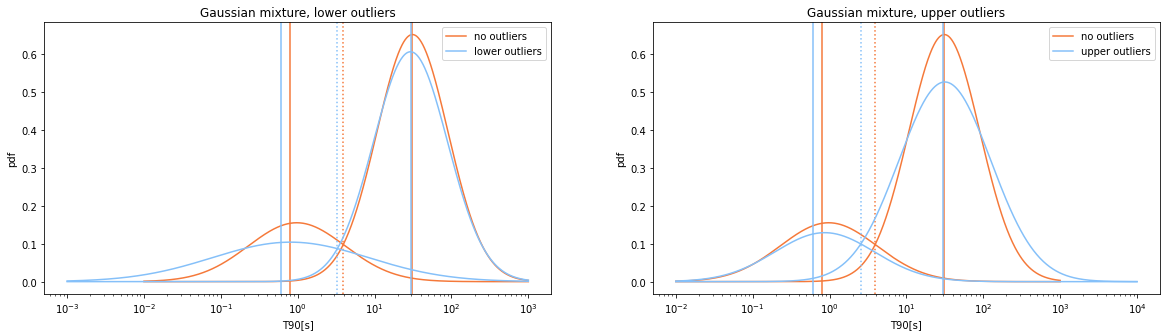

In [175]:
# plot model 

fig = plt.figure(figsize=(20,5))


#----------------------------- GM upper outliers --------------
ax1 = fig.add_subplot(121) 
#plt.hist(T90_upper, bins=np.logspace(-2,4,40), histtype='step')
plt.plot(x, modes[0], color=color[0], label='no outliers')
plt.plot(x, modes[1], color=color[0])
plt.axvline(GMcenters[0],color=color[0])
plt.axvline(GMcenters[1],color=color[0])
plt.axvline(GMtreshold,color=color[0], linestyle='dotted')

plt.plot(xlower, modes_lower[0], color=color[2], label='lower outliers')
plt.plot(xlower, modes_lower[1], color=color[2])
plt.axvline(GMcenters_lower[0],color=color[2])
plt.axvline(GMcenters_lower[1],color=color[2])
plt.axvline(GMtreshold_lower,color=color[2], linestyle='dotted')

plt.legend()
plt.xlabel('T90[s]')
plt.title('Gaussian mixture, lower outliers')
plt.ylabel('pdf')
plt.semilogx()


ax2 = fig.add_subplot(122) 
#plt.hist(T90_lower, bins=np.logspace(-3,3,40), histtype='step')
plt.plot(x, modes[0], color=color[0], label='no outliers')
plt.plot(x, modes[1], color=color[0])
plt.axvline(GMcenters[0],color=color[0])
plt.axvline(GMcenters[1],color=color[0])
plt.axvline(GMtreshold, color=color[0], linestyle='dotted')

plt.plot(xupper, modes_upper[0], color=color[2], label='upper outliers')
plt.plot(xupper, modes_upper[1], color=color[2])
plt.axvline(GMcenters_upper[0],color=color[2])
plt.axvline(GMcenters_upper[1],color=color[2])
plt.axvline(GMtreshold_upper,color=color[2], linestyle='dotted')

plt.legend()
plt.xlabel('T90[s]')
plt.title('Gaussian mixture, upper outliers')
plt.ylabel('pdf')
plt.semilogx();

Okay so: the treshold moves more for upper outliers since the width of LGRB distribution increases to classify those data.
As a consequence the intersection between the two distributions happens at lower durations.


Let's see if something changes if I add a third mode in the latter case!

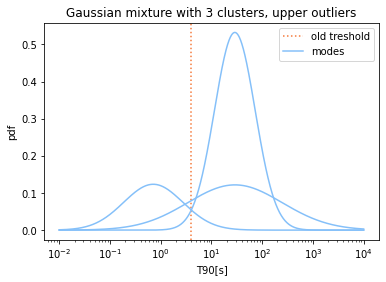

In [176]:
# Gaussian Mixture

gm_upper = GaussianMixture(n_components=3).fit(np.log10(T90_upper)[:, np.newaxis])
gmlabels_upper = gm_upper.predict(np.log10(T90_upper)[:, np.newaxis]) 

xupper = np.logspace(-2, 4, 1000)
pdf_upper = np.exp(gm_upper.score_samples(np.log10(xupper)[:, np.newaxis]))
reps_upper = gm_upper.predict_proba(np.log10(xupper[:, np.newaxis]))
modes_upper = [reps_upper[:,0] * pdf_upper, reps_upper[:,1] * pdf_upper, reps_upper[:,2] * pdf_upper]
 
plt.axvline(GMtreshold, color=color[0], linestyle='dotted', label='old treshold')
plt.plot(xupper, modes_upper[0], color=color[2], label='modes')
plt.plot(xupper, modes_upper[1], color=color[2])
plt.plot(xupper, modes_upper[2], color=color[2])

plt.xlabel('T90[s]')
plt.title('Gaussian mixture with 3 clusters, upper outliers')
plt.ylabel('pdf')
plt.legend()
plt.semilogx();

The treshold is the same as without outliers!
The third Gaussian is not centered on outliers since outliers distribution is not gaussian but loguniform. 
Outliers are thus modeled with the right tail of a wider gaussian with the same center as the one of LGRB. 

-------------
### Other variables

#### Redshift

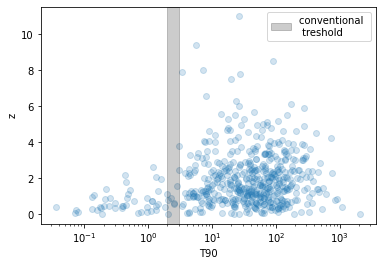

In [280]:
mask1 = np.logical_and(T90 != -999, redshift != -999)
plt.scatter(T90[mask1], redshift[mask1], alpha=0.2)
plt.axvspan(2, 3, alpha=0.2, color='black', label='conventional \n treshold')

plt.semilogx()
plt.xlabel('T90')
plt.ylabel('z')
plt.legend();

SGRB with measured redshift seem much less than LGRB.
Let's see the fraction of SGRB and LGRB for which both T90 and z are measured (where we classify short and long with the treshold at $3s$):

In [281]:
# TrueLabels = 0 for SGRB, 1 for LGRB
y =  []
for i in range(len(T90[mask1])):
    if T90[mask1][i]>3:
        y.append(1)
    else:
        y.append(0)  
        
y = np.array(y)

fraction_short = 100*len(T90[mask1][y==0])/len(T90[mask][TrueLabels==0])
fraction_long =  100*len(T90[mask1][y==1])/len(T90[mask][TrueLabels==1])

print('#SGRB where both T90 and Z are measured divided by #SGRB where only T90 is measured: %.2f'
      %fraction_short, '%');
print('#LGRB where both T90 and Z are measured divided by #LGRB where only T90 is measured: %.2f'
      %fraction_long , '%');

#SGRB where both T90 and Z are measured divided by #SGRB where only T90 is measured: 3.72 %
#LGRB where both T90 and Z are measured divided by #LGRB where only T90 is measured: 8.83 %


Is it more difficult to measure z for SGRBs than for LGRBs?

SGRB seem also at lower redshift.
Is it the real population distribution or is due to selection effects?

Let's look at fluence now:

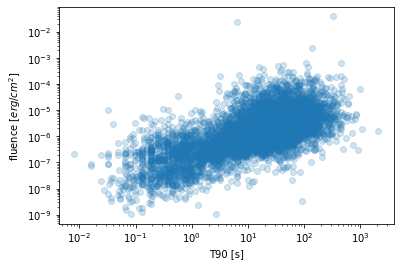

In [282]:
mask2 = np.logical_and(T90 != -999, fluence != -999)
plt.scatter(T90[mask2], fluence[mask2], alpha=0.2)

plt.loglog()
plt.xlabel('T90 [s]')
plt.ylabel(r'fluence $[erg/cm^{2}]$');

Due to their short duration, fluence values are lower fro SGRBs, making their localization more difficult!

Since the fluence is time integrated, I divide it for the corresponding duration.

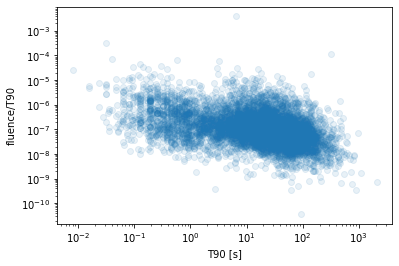

In [283]:
plt.scatter(T90[mask2], fluence[mask2]/T90[mask2], alpha=0.1)

plt.loglog()
plt.xlabel('T90 [s]')
plt.ylabel(r'fluence/T90');

It seems that on average fluence per unit time is higher for SGRBs.
I classify data using GM:

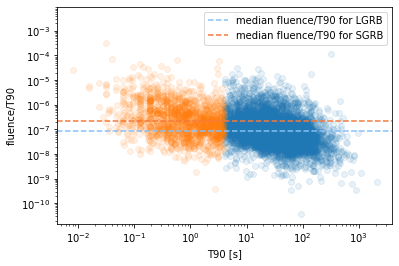

In [372]:
''' I add 1 to flunce/T90 when I classify it since to classify it i need to do the log and
the log of smth close to 0 gives nan'''
X = np.array([T90[mask2], fluence[mask2]/T90[mask2]+1]).T  
x = np.array([T90[mask2], fluence[mask2]/T90[mask2]]).T


# fit the model: 2 Gaussians
gm = GaussianMixture(n_components=2, random_state=2).fit(np.log10(X))
# pdf model
labels = gm.predict(np.log10(X))

medianFluence_sgrbs = np.median(x[:,1][labels==1])
medianFluence_lgrbs = np.median(x[:,1][labels==0])                                
                                
plt.scatter(x[:,0][labels==0], x[:,1][labels==0], alpha=0.1)
plt.scatter(x[:,0][labels==1], x[:,1][labels==1], alpha=0.1)
plt.axhline(medianFluence_lgrbs, color=color[2], linestyle='--', label='median fluence/T90 for LGRB')
plt.axhline(medianFluence_sgrbs, color=color[0], linestyle='--', label='median fluence/T90 for SGRB')
plt.loglog()
plt.xlabel('T90 [s]')
plt.ylabel(r'fluence/T90')
plt.legend();

Median fluence per unit time is actually higher!

At least, I look if there is any correlation between fluence and redshift.


 Label = 0: SGRB 
 Label = 1: LGRB. 
 Classification of SGRB/LGRB made with the conventional treshold of 3s.


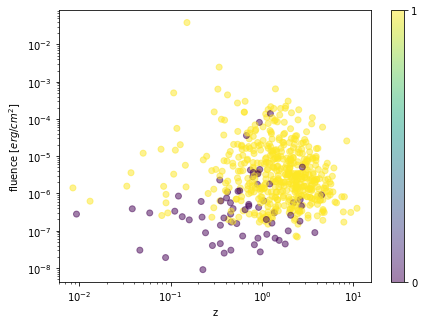

In [373]:
fig = plt.figure(figsize=(7,5))
mask3 = np.logical_and(redshift != -999, fluence != -999, T90 != -999)
labels = []
for i in range(len(redshift[mask3])):
    if T90[mask3][i]>3 :
        labels.append(1)
    else:
        labels.append(0)

im = plt.scatter(redshift[mask3], fluence[mask3], c=labels, alpha=0.5)
cbar = fig.colorbar(im)
tick_locs = np.arange(2)
cbar.set_ticks(tick_locs)
print('\n Label = 0: SGRB \n',
       'Label = 1: LGRB. \n Classification of SGRB/LGRB made with the conventional treshold of 3s.')

plt.loglog()
plt.xlabel('z')
plt.ylabel(r'fluence $[erg/cm^{2}]$');

At $z \sim 1$ there are some SGRBs with fluences higher than $10^{-6} erg cm^{-2}$... however SGRB data are not enough to see if there is some correlation between redshift and fluence.

In conclusion:

LGRBs origin is associated with the collapse of a massive star. 
Instead SGRBs probabily origin from a NS-NS merger. 
This would explain the distribution of the two populations with redshift.
However in our sample we don't have enough data for SGRB redshift to study its correlation with other variables.

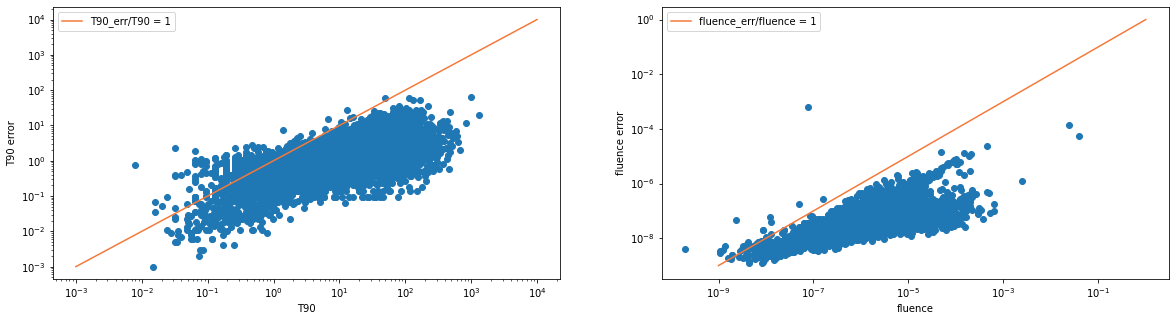

In [338]:
# ERRORS

fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(121) 

maskerr = np.logical_and(T90 != -999, T90_error != -999)
plt.scatter(T90[maskerr], T90_error[maskerr])
xgrid = np.logspace(-3,4,100)
plt.plot(xgrid, xgrid, color=color[0], label='T90_err/T90 = 1')
plt.xlabel('T90')
plt.ylabel('T90 error')
plt.legend()
plt.loglog();

ax2 = fig.add_subplot(122) 

maskerr = np.logical_and(fluence != -999, fluence_error != -999)
plt.scatter(fluence[maskerr], fluence_error[maskerr])
xgrid = np.logspace(-9,0,100)
plt.plot(xgrid, xgrid, color=color[0], label='fluence_err/fluence = 1')
plt.xlabel('fluence')
plt.ylabel('fluence error')
plt.legend()
plt.loglog();